### Anime Recommender System- Anime Recommendations Database (Collaborative Filtering)

Lets begin our implementation of a Collaborative Filtering Recommender System in Python. For this exercise we will be using the Anime Recommendations Database which contains recommendation data from 76,000 users at myanimelist.net and K-Nearest Neighbors clustering algorithm. 

My animelist.net is a popular site for viewing Anime online abroad which is self proclaimed as the world's most active online anime and manga community and database. 
There are two CSV files we will work with which are called anime.csv and ratings.csv. 

##### The anime.csv file contains many of the data related to the anime series including: 
* anime_id: (unique identifier for each anime)
* name: (anime name) 
* genre: (what genres the anime belongs to) 
* type: (Type: movie, tv etc.) 
* episodes: (how many episodes does the show have?) 
* rating: (average rating out of 10) 
* members: (total members who are a part of the anime group on the website who have subscribed to the anime) 

##### The ratings.csv contains individual ratings of anime by users of the website and contains: 
* user_id (unique user id) 
* anime_id that was rated (unique identifier for anime rated) 
* rating- (rating given to anime by that user) 

These two data files will be utilized to build a recommender system. The goal of this dataset is to build a recommender system based on just viewing history and ratings. It is perhaps the biggest dataset related to anime customer preferences in the world. 

All Acknowledgements go to the myanimelist.net API which provides this data and it can also be downloaded from the below Kaggle Link: 

https://www.kaggle.com/CooperUnion/anime-recommendations-database

![Anime](https://kaggle2.blob.core.windows.net/datasets-images/571/1094/c633ae058ddaa59f43649caac1748cf4/dataset-original.png)

#### Preliminary Stuff - Import Packages/Data

Lets first import the packages we'll need to create the recommender system including pandas, numpy, csr_matrix, and NearestNeighbors. 

In [1]:
import pandas as pd
import numpy as np 
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
%matplotlib inline 

Then we will read the two files rating.csv and anime.csv into the dataframes ratings and anime respectively. 

In [2]:
ratings = pd.read_csv('rating.csv')
anime = pd.read_csv('anime.csv')

#### Data Exploration

The next step is the data exploration step where we will get a feel for the data using various pandas functions. Performing the head function on the ratings and anime data frames gives us a quick insight into how the tables are structured. 

In [3]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Lets sort the anime values by members which is the amount of people subscribed to the anime. We can use this measure to illustrate the most popular animes on the website. 
It looks like the top five animes were Death Note, Shingeki no Kyojin, Sword Art Online, Fullmetal Alchemist: Brotherhood, and Angel Beats! 

I notice that Naruto has alot of members despite having a 7.81 rating. I guess people are on the fence about this anime despite its popularity. 

In [5]:
anime.sort_values('members', ascending= False)[:10]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


Lets look at some more descriptive statistics for the anime and ratings table. There are two things that really stuck out to me when looking at these statistics.  There are animes in this dataset with only 5 members while the most members subscribed is around 1,013,917. This is quite a huge difference between the min and max. In addition, 25 % of animes have 225 members or less while 25 % seem to have over 9,000 members.  

In [6]:
round(anime.describe(),2)

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


When looking at the describe function and ratings we can clearly see the min is -1 and mean is around 7. We will need to address the -1's in our future recommender model. According to the dataset providers, -1 indicates that a user watched the anime but did not provide a recommendation. This would indicate indiference to the anime meaning we can drop it from the dataset in the data cleaning phase as it would not really help our model. 

In [7]:
round(ratings.describe(),2)

,user_id,anime_id,rating
count,7813737.00,7813737.00,7813737.00
mean,36727.96,8909.07,6.14
std,20997.95,8883.95,3.73
min,1.00,1.00,-1.00
25%,18974.00,1240.00,6.00
50%,36791.00,6213.00,7.00
75%,54757.00,14093.00,9.00
max,73516.00,34519.00,10.00


Lets now plot the distribution of user ratings and see how that looks. It looks like a majority of the ratings are either -1 (which represents no rating) or are in the 7 or above range. 

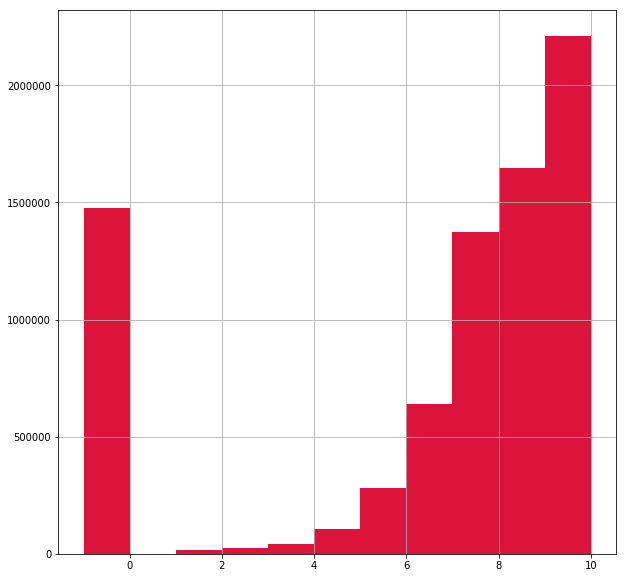

In [8]:
ratings['rating'].hist(bins=11, figsize=(10,10), color = 'crimson')

#### Data Cleaning

Now we will begin the data cleaning phase where we will clean up anything odd about the data and transform it into a format that our k-nearest neighbors algorithm can be fitted on. 

As for step one, we will want to filter down the system to be greater than 10000 recommendations to improve quality of recommendations and reduce noise in the data. We dont want the recommender to be recommending animes with a low amount of members. Lets set a threshold of .75 percentile to 100th percentile shows for member totals and filter everything else out. 

In [9]:
print(anime['members'].quantile(np.arange(.65, 1, .01)))

0.65      4070.35
0.66      4416.90
0.67      4778.86
0.68      5135.48
0.69      5600.00
0.70      6061.20
0.71      6601.09
0.72      7131.96
0.73      7845.67
0.74      8564.28
0.75      9437.00
0.76     10305.04
0.77     11475.93
0.78     12487.62
0.79     13685.70
0.80     14932.80
0.81     16510.25
0.82     18318.44
0.83     20135.61
0.84     22158.56
0.85     24524.10
0.86     27758.06
0.87     31230.49
0.88     35341.16
0.89     39927.60
0.90     45188.70
0.91     51271.94
0.92     58321.60
0.93     68153.97
0.94     80609.88
0.95     93164.30
0.96    108663.84
0.97    139500.67
0.98    187928.20
0.99    276774.30
Name: members, dtype: float64


In [10]:
anime = anime[anime['members'] > 10000]

Next, lets check for null values as we dont really need these data values in the model. It looks like we have null values in the genre, type, and rating columns so lets drop these values. 

In [11]:
anime.isnull().any()

anime_id    False
name        False
genre        True
type         True
episodes    False
rating       True
members     False
dtype: bool

In [12]:
anime.isnull().sum()

anime_id     0
name         0
genre        2
type         4
episodes     0
rating      43
members      0
dtype: int64

In [13]:
anime = anime.dropna()

Now that we have cleaned the anime dataframe lets work on cleaning the ratings dataframe. If you remember from our initial describe function, there are some -1's in our data which need to be removed. These -1's represent a watch by the user but no rating. Lets just filter the ratings table to include 0 and above for this exercise. 

In [14]:
ratings = ratings[ratings.rating >= 0]

We can see now with the describe function that the lowest rating is 1 and the highest rating is 10. The database has 6,337,241 ratings and the average was an 8 on the website. (Filtered down from nearly 8 million ratings) Now thats alot of ratings and data ! 

In [15]:
round(ratings.describe(),2)

,user_id,anime_id,rating
count,6337241.00,6337241.00,6337241.00
mean,36747.91,8902.87,7.81
std,21013.40,8882.00,1.57
min,1.00,1.00,1.00
25%,18984.00,1239.00,7.00
50%,36815.00,6213.00,8.00
75%,54873.00,14075.00,9.00
max,73516.00,34475.00,10.00


Now that data cleaning is complete, we can merge the data frames to create one large df called mergeddf. This merge function is extremely important if you ever need to work with multiple data sources in the future. It allows you to join two tables (data frames) by a matching identifier or key. We can now see each user that rated a specific anime in one table.  

In [16]:
mergeddf = ratings.merge(anime, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
mergeddf.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


In [17]:
round(mergeddf.describe(),2)

,user_id,anime_id,rating_user,rating,members
count,5957004.00,5957004.00,5957004.00,5957004.00,5957004.00
mean,36665.80,9023.38,7.87,7.74,196030.78
std,21030.91,8920.21,1.54,0.62,191317.96
min,1.00,1.00,1.00,2.37,10005.00
25%,18911.00,1195.00,7.00,7.35,57029.00
50%,36534.00,6500.00,8.00,7.74,130689.00
75%,54851.00,14345.00,9.00,8.17,271484.00
max,73516.00,34240.00,10.00,9.37,1013917.00


Now that the merge has been completed successfully, lets drop all of the columns we dont need and remove duplicates as this will affect the creation of our sparse matrix. We also only will need the user_id, name, and rating_user columns to create the recommender system. 

In [18]:
mergeddf = mergeddf[['user_id','name','rating_user']]
mergeddf = mergeddf.drop_duplicates(['user_id','name'])

In [19]:
mergeddf.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


Next, we will pivot our dataset to have the index as the anime name (rows) with each user as a column. A user will have a rating number in their column/respective anime row if they reviewed the anime. We will also fill the non-reviewed NA values to 0. When looking at anime_pivot through the head function we can clearly see this has been accomplished. 

We will also create a sparse matrix called anime_pivot_sparse with the csr_matrix function from scipy. 

In [20]:
anime_pivot = mergeddf.pivot(index= 'name',columns='user_id',values='rating_user').fillna(0)
anime_pivot_sparse = csr_matrix(anime_pivot.values)

A sparse Matrix can be seen below. It Essentially represents each user as a vector of ratings. Each user who has rated an anime will have a number at the associated anime (index) row. Any show that has not been rated will be represented as a 0. The majority of elements in a sparse matrix will be 0. 

Now, lets run the head function and see what our new Sparse Matrix really looks like. It looks like we have 73516 users with ratings. The head function below shows what the top 10 animes in our sparse matrix look like. 

In [21]:
anime_pivot.head(10)

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Intermezzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Liminality,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Quantum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Build Recommender System with k-nearest neighbors 

To build our Recommender System we will be using the K-Nearest Neighbors model with the number of neighbors parameter set as 9. We will also be utilizing the brute force method and cosine distance metric. We will then fit the model to the sparse matrix we just created.  

What is the K-Nearest Neighbors Algorithm ? 
It is a non-parametric clustering algorithm generally used for classification and regression. In the case of this tutorial, it is used to find the similarity between the queried anime and other animes based on users past rating vectors.

Nearest neighbors means exactly what it states in this example. For example, lets say we queried the anime (Dragon Ball), in this case the nearest neighbors model would look at the users who have the greatest similarity based on what they viewed and recommend similar things they have watched. The animes with the highest similar user ratings based on cosine distance from a vector perspective will be considered the nearest neighbors and recommendations in the model. 


![Comparison](https://i2.wp.com/dataaspirant.com/wp-content/uploads/2015/01/first.png?w=940)


In [22]:
knn = NearestNeighbors(n_neighbors=9,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(anime_pivot_sparse)

Lets try our Model now and try to generate the top 10 recommendations for each anime and see what our model recommends. The lower the distance the better in this case as this would indicate more similarity between the show and users who watch the show. 

#### Test Our Recommender System

##### Search Function

I first created a search function as I imagined it would be quite hard to find specific animes in the dataset. Lets first look for Hajime and see if we can get Hajime no Ippo to return. It looks like we have quite a few animes with the name Hajime no Ippo. 

In [23]:
user_input = input("Search for Anime: ")

def searchanime(string):
    print(anime_pivot[anime_pivot.index.str.contains(string)].index[0:])  
searchanime(user_input)

Index(['Bokura wa Minna Kawaisou: Hajimete no', 'Hajime no Ippo',
       'Hajime no Ippo: Boxer no Kobushi', 'Hajime no Ippo: Champion Road',
       'Hajime no Ippo: Mashiba vs. Kimura', 'Hajime no Ippo: New Challenger',
       'Hajime no Ippo: Rising', 'Kamisama Hajimemashita',
       'Kamisama Hajimemashita OVA', 'Kamisama Hajimemashita: Kako-hen',
       'Kamisama Hajimemashita◎', 'Kyou, Koi wo Hajimemasu',
       'Natsume Yuujinchou: Nyanko-sensei to Hajimete no Otsukai',
       'Re:Petit kara Hajimeru Isekai Seikatsu',
       'Re:Zero kara Hajimeru Break Time',
       'Re:Zero kara Hajimeru Isekai Seikatsu',
       'Sekirei: Hajimete no Otsukai'],
      dtype='object', name='name')


The next step is to test our recommender system where we will input anime names to return 10 recommendations for each anime. Lets hope we get some good recommendations! 

##### Recommendations for Hajime no Ippo: 

In [24]:
Anime = 'Hajime no Ippo'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Hajime no Ippo:

1: Hajime no Ippo: New Challenger with distance: 0.16171263372777
2: Hajime no Ippo: Champion Road with distance: 0.30597377816318394
3: Hajime no Ippo: Mashiba vs. Kimura with distance: 0.34948858340614675
4: Hajime no Ippo: Rising with distance: 0.3635742899878238
5: Hajime no Ippo: Boxer no Kobushi with distance: 0.5808237633855784
6: Great Teacher Onizuka with distance: 0.6271421261955552
7: Shijou Saikyou no Deshi Kenichi with distance: 0.6428821544076411
8: Major S1 with distance: 0.6575993793656698
9: Major S2 with distance: 0.6623633646779645
10: One Outs with distance: 0.6644591854339764


#### Recommendations for Pokemon:

In [25]:
Anime = 'Pokemon'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Pokemon:

1: Pokemon Advanced Generation with distance: 0.4431031300032995
2: Pokemon: Mewtwo no Gyakushuu with distance: 0.5273494641299561
3: Pokemon: Kesshoutou no Teiou Entei with distance: 0.5434061482894894
4: Pokemon: Maboroshi no Pokemon Lugia Bakutan with distance: 0.5455007237642211
5: Digimon Adventure with distance: 0.5687834394950073
6: Pokemon: Celebi Toki wo Koeta Deai with distance: 0.5873511824078185
7: Pokemon Diamond &amp; Pearl with distance: 0.5907299565599141
8: Yu☆Gi☆Oh! Duel Monsters with distance: 0.6044038180543316
9: Pokemon Advanced Generation: Mew to Hadou no Yuusha Lucario with distance: 0.6070726790837473
10: Dragon Ball Z with distance: 0.6207032862371291


#### Recommendations for Dragon Ball:

In [26]:
Anime = 'Dragon Ball'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Dragon Ball:

1: Dragon Ball Z with distance: 0.23832943608906398
2: Dragon Ball GT with distance: 0.28588038713390795
3: Naruto with distance: 0.5771994935064382
4: Death Note with distance: 0.5888544933859206
5: Fullmetal Alchemist with distance: 0.614951748870641
6: Dragon Ball Z Movie 08: Moetsukiro!! Nessen, Ressen, Chougekisen with distance: 0.6193327841505586
7: Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!! with distance: 0.621487480304885
8: Dragon Ball Kai with distance: 0.6229613870214002
9: Digimon Adventure with distance: 0.6231310497448332
10: Dragon Ball Z Movie 05: Tobikkiri no Saikyou tai Saikyou with distance: 0.6270581114743166


#### Recommendations for Kimi no Na wa:

In [27]:
Anime = 'Kimi no Na wa.'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Kimi no Na wa.:

1: Boku dake ga Inai Machi with distance: 0.6855242894481091
2: Re:Zero kara Hajimeru Isekai Seikatsu with distance: 0.6968551384446042
3: Shigatsu wa Kimi no Uso with distance: 0.703281384251974
4: ReLIFE with distance: 0.7191316277184874
5: One Punch Man with distance: 0.7426460533821271
6: Charlotte with distance: 0.7434996132820642
7: Noragami Aragoto with distance: 0.7486936229508915
8: Shokugeki no Souma with distance: 0.7585646506908518
9: Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku with distance: 0.7602916580493286
10: Noragami with distance: 0.7612671872707739


#### Recommendations for Hunter x Hunter:

In [28]:
Anime = 'Hunter x Hunter'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Hunter x Hunter:

1: Hunter x Hunter: Greed Island with distance: 0.30129951088727835
2: Hunter x Hunter: Greed Island Final with distance: 0.3083582686288663
3: Hunter x Hunter OVA with distance: 0.3108793525788244
4: Hunter x Hunter (2011) with distance: 0.6907013813572384
5: Hajime no Ippo with distance: 0.6983307629235063
6: Slam Dunk with distance: 0.7081438549910755
7: Fullmetal Alchemist with distance: 0.7084124786289742
8: Naruto with distance: 0.7090694095508168
9: Yuu☆Yuu☆Hakusho with distance: 0.7123776276729162
10: Rurouni Kenshin: Meiji Kenkaku Romantan with distance: 0.721888632207479


### Conclusion

This concludes our Collaborative Filtering Recommender System with the Anime Recommendations Dataset. This may not be the best recommender system out there on the market today but it serves as a good introduction to the world of recommender systems. From my personal viewing experience, I feel the models were pretty accurate in regards to Anime recommendations for the above animes. 